# Study on the tolerance
In this notebook, we study the dependence on the tolerance used to split the eigenspace of the NTK.

In order to compute the analytical solution of the gradient flow equation, we need to split the space of the NTK into two components. The first one is the kernel, hence the space of zero eigenvalues. The second one is the space orthogonal to the kernel, which comprises non-zero eigenvalues. Despite this sounds trivial to do on a theoretical basis, it presents some technical difficulties that must be assessed carefully. Indeed, the spectrum of the NTK is characterised by a hierarchy where the first few leading eigenvalues are non-zero, and then they quickly drop to small values until they become effectively zero. This fact introduces numerical instability, as the numerical precision is finite and some small values should be considered effectively zero. The choice of the tolerance that is used to cut off this values is of extreme importance. If we cut too much, we loose physical information. On the other hand, if we allow too many eigenvalues, we are including numerical noise and the solution becomes unstable.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)

from pathlib import Path

from yadlt.model import PDFmodel
from yadlt.distribution import Distribution

In [2]:
# Extension for the weights file
WEIGHTS_TOKEN = 'weights.h5'
def select_weight(epoch: int):
  return f"epoch_{int(epoch)}.{WEIGHTS_TOKEN}"

In [3]:
# Path to the fit folder
FIT_FOLDER = Path('../Results/fits/250604-ac-02-L1')

In [4]:
# Get learning rate from config file
import yaml
try:
  with open(FIT_FOLDER / 'metadata.yaml', 'r') as f:
    metadata = yaml.safe_load(f)
    learning_rate = metadata['arguments']['learning_rate']

except FileNotFoundError:
  print("Metadata file not found. Using default learning rate.")
  learning_rate = 1.e-5

In [5]:
# Extract replicas from the fit folder
replicas_folders = [f for f in FIT_FOLDER.iterdir() if f.is_dir() and 'replica' in str(f)]
replicas_folders.sort()
replicas = len(replicas_folders)

# For each replicas, load the epochs and data
replica_epochs_dict = {}
for replica_folder in replicas_folders:
  epochs = [f for f in replica_folder.iterdir() if f.is_file() and WEIGHTS_TOKEN in str(f)]
  epochs.sort()
  replica_epochs_dict[replica_folder.name] = epochs

In [6]:
# Find common epochs
# Different replicas may have different epochs, so we need to find the common ones
common_epochs = set()
for replica, epochs in replica_epochs_dict.items():
  aux = set()
  for epoch in epochs:
    epoch_num = int(epoch.name.split('.')[0].split('_')[1])
    aux.add(epoch_num)
  
  if len(common_epochs) == 0:
    common_epochs = aux
  else:
    common_epochs.intersection_update(aux)

common_epochs = sorted(list(common_epochs))
print(f"Common epochs: {common_epochs}")

Common epochs: [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000]


In [7]:
from yadlt import data
from pathlib import Path
import importlib.resources as pkg_resources

# Load Tommaso's file
data_path = Path(pkg_resources.files(data) / "BCDMS_data")
fk_grid = np.load(data_path / 'fk_grid.npy')
FK = np.load(data_path / 'FK.npy')
f_bcdms = np.load(data_path / 'f_bcdms.npy')
Cy = np.load(data_path / 'Cy.npy')
Cinv = np.linalg.inv(Cy)

# Compute M
M = FK.T @ Cinv @ FK

In [8]:
# Extract the last common epoch from the ensemble of replicas
xT3_training = Distribution('xT3_training')
print(f'Loading {len(replicas_folders)} replicas...', end='\t')
for replica_path in replicas_folders:
    replica = replica_path.name
    last_epoch = replica_epochs_dict[replica][-1]

    model = PDFmodel.load_model(replica_path / 'config.json', last_epoch)
    xT3_training.add(model.predict().numpy().reshape(-1))
print('Done!')

# Compute T3 from xT3
T3_training = xT3_training.apply_operator(b=fk_grid, operator=lambda a, b: np.true_divide(a, b), axis=0, name=f'T3 at the end of the training')

Loading 100 replicas...	Done!


In [9]:
# Load the data used to fit the replicas
data_by_replica_original = Distribution("Original replicas of the data")

for rep in range(replicas):
  data = np.load(FIT_FOLDER / f'replica_{rep+1}' / 'data.npy')
  data_by_replica_original.add(data)

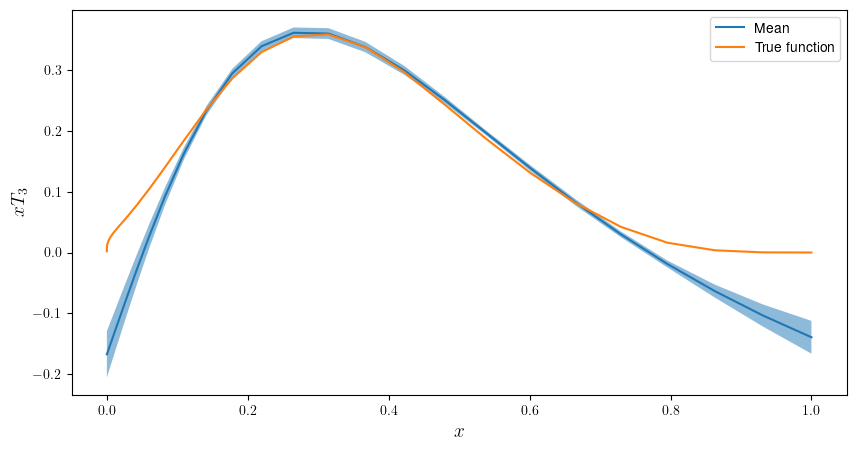

In [10]:
# Plot the ensemble of xT3 at the end of the training
plt.figure(figsize=(10, 5))
plt.plot(fk_grid, xT3_training.get_mean(), label='Mean')
plt.fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), alpha=0.5)
plt.plot(fk_grid, f_bcdms, label='True function')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$xT_3$', fontsize=14)
plt.legend()
plt.show()

The plot looks good, which means that the training actually worked out!

In [11]:
import tensorflow as tf
@tf.function(reduce_retracing=True)
def compute_ntk_static(inputs, model, outputs):
    """
    Optimized Neural Tangent Kernel computation.
    This function computes the NTK in a more efficient way by
    leveraging static shapes and avoiding unnecessary operations.

    This function avoids reretracing by using `tf.function` with `reduce_retracing=True`.

    Albeit a similar function exists in the model class, this one is optimized and
    avoid retracing by using static shapes and a single operation to compute the NTK.

    TODO: The two functions should be merged, but this requires some refactoring
    """
    with tf.GradientTape(persistent=False) as tape:
        predictions = model(inputs)
        jacobian = tape.jacobian(predictions, model.trainable_variables)

    input_size = inputs.shape[0]

    if outputs == 1:
        # Concatenate jacobians along the parameter dimension
        jac_list = []
        for jac in jacobian:
            # Flatten dimension
            jac_flat = tf.reshape(jac, (input_size, -1))
            jac_list.append(jac_flat)
        
        # Concatenate all parameter jacobians
        full_jacobian = tf.concat(jac_list, axis=1)  # Shape: [input_size, total_params]

          # Compute NTK in one operation
        ntk = tf.matmul(full_jacobian, full_jacobian, transpose_b=True)
        
    else:
        # Multiple outputs case
        raise NotImplementedError(
            "Multiple outputs optimization not implemented. Use original method."
        )

    return ntk

In [12]:
# Get one model structure to use for NTK computation
dummy_model = PDFmodel.load_model(replicas_folders[0] / 'config.json', replicas_folders[0] / select_weight(0)).model

# Calling the model with a dummy input makes sure the model is built
# Not sure this is strictly necessary, but it is a good practice
_ = dummy_model(tf.convert_to_tensor(fk_grid.reshape(-1, 1)))

def process_replica_by_epoch(replica_path: Path, epoch: int, tol=1e-5):
    """
    Process a single replica for a given epoch,
    """
    # Compute the NTK for the current replica and epoch
    dummy_model.load_weights(replica_path / select_weight(epoch))
    NTK = compute_ntk_static(tf.convert_to_tensor(fk_grid.reshape(-1, 1)), dummy_model, outputs=1)

    size = NTK.shape[0]

    # Compute eigenvalues and eigenvectors of the NTK
    eigenvalues, Z = np.linalg.eigh(NTK)
    eigenvalues = np.flip(eigenvalues)
    Z = np.flip(Z, axis=1)

    # Compute frobenius norm
    frob_norm = np.sqrt(np.sum([s**2 for s in eigenvalues]))

    # Split the NTK space
    rtol = tol * eigenvalues.max()
    perp_mask = eigenvalues > rtol
    parallel_mask = ~perp_mask
    Lambda_perp  = eigenvalues[perp_mask]
    Z_perp = Z[:, perp_mask]
    Z_parallel = Z[:, parallel_mask]

    # Parallel projector
    P_parallel = np.empty((size, size))
    P_perp = np.empty((size, size))
    P_parallel = np.dot(Z_parallel, Z_parallel.T)
    P_perp = np.dot(Z_perp, Z_perp.T)

    # Compute similarity transformation
    Lambda_perp_sqrt = np.sqrt(Lambda_perp)
    Lambda_perp_sqrt_inv = 1.0 / Lambda_perp_sqrt
    P = np.diag(Lambda_perp_sqrt_inv) @ Z_perp.T
    P_inv = Z_perp @ np.diag(Lambda_perp_sqrt)

    # Symmetric operator
    H_perp = np.diag(Lambda_perp_sqrt) @ Z_perp.T @ M @ Z_perp @ np.diag(Lambda_perp_sqrt)

    # Eigendecomposition of H_perp
    h, W = np.linalg.eigh(H_perp)
    hinv = 1 / h

    # Compute Q and its inverse
    Q = P_inv @ W
    Qinv = W.T @ P

    # Pad quantities to ensure they are square matrices
    Q = np.pad(Q, ((0, 0), (0, Q.shape[0] - Q.shape[1])), mode='constant', constant_values=0)
    Qinv = np.pad(Qinv, ((0, Qinv.shape[1] - Qinv.shape[0]), (0, 0)), mode='constant', constant_values=0)
    hinv = np.pad(hinv, (0, Q.shape[0] - hinv.shape[0]), mode='constant', constant_values=0)
    h = np.pad(h, (0, Q.shape[0] - h.shape[0]), mode='constant', constant_values=0)

    return {
        'NTK': NTK,
        'frob_norm': frob_norm,
        'eigenvalues': eigenvalues,
        'P_parallel': P_parallel,
        'P_perp': P_perp,
        'Q': Q,
        'Qinv': Qinv,
        'h': h,
        'hinv': hinv
    }

In [13]:
def compute_evolution_operator_at_inf(reference_epoch, tol):
    """
    Computes operators at infinity
    
    Parameters:
    - NTK: Neural Tangent Kernel matrix
    - FK: Forward map matrix
    - Cy: Covariance matrix
    - M: M matrix (typically FK^T @ Cy^-1 @ FK)
    - t: time (epoch)
    
    Returns:
    - U: Evolution operator at time t
    - V: Second operator needed for the full solution
    """
    # Initialize distributions
    P_parallel = Distribution(name=f'P at parallel epoch {reference_epoch}', size=replicas, shape=(fk_grid.size, fk_grid.size,))
    Q = Distribution(name=f'Q at epoch {reference_epoch}', size=replicas, shape=(fk_grid.size, fk_grid.size,))
    Qinv = Distribution(name=f'Q inv. at epoch {reference_epoch}', size=replicas, shape=(fk_grid.size, fk_grid.size,))
    hinv = Distribution(name=f'hinv at epoch {reference_epoch}', size=replicas, shape=(fk_grid.size,))

    # Loop over each replica
    for replica_path in replicas_folders:
      
      result = process_replica_by_epoch(replica_path, reference_epoch, tol=tol)

      P_parallel.add(result['P_parallel'])
      hinv.add(result['hinv'])
      Q.add(result['Q'])
      Qinv.add(result['Qinv'])
  
    Qt = Q.transpose()
    Qtilde = Qt @ M @ P_parallel
    T_tilde = Qt @ FK.T @ Cinv

    hinv = hinv.make_diagonal()
    
    U_check = Q @ hinv @ Qtilde
    V = Q @ hinv @ T_tilde
    
    U = U_check + P_parallel
    
    return U, V

In [14]:
# Generate model at initialisation
replicas = len(replicas_folders)
seed = 1423413
xT3_0 = Distribution('xT3 at initialisation')
for rep in range(replicas):
  model = PDFmodel(
          dense_layer='Dense',
          input=fk_grid,
          outputs=1,
          architecture=[28,20],
          activations=['tanh', 'tanh'],
          kernel_initializer='GlorotNormal',
          user_ki_args=None,
          seed=seed + rep)

  xT3_0.add(model.predict().numpy().reshape(-1))

In [15]:
def produce_plot(tol_dict, ref_epoch):
  fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})
  for tol_dict in tol_dict:

    tol = tol_dict['tol']
    color = tol_dict['color']
    print(f"Computing evolution operator at infinity for tolerance {tol}...")
    U, V = compute_evolution_operator_at_inf(ref_epoch, tol)
    xf_t = U @ xT3_0 + V @ data_by_replica_original

    # xf linear
    axs[0].plot(fk_grid, xf_t.get_mean(), label=f'tol = {tol}', color=color)
    axs[0].fill_between(fk_grid, xf_t.get_mean() - xf_t.get_std(), xf_t.get_mean() + xf_t.get_std(), alpha=0.5, color=color)

    # xf log
    axs[1].plot(fk_grid, xf_t.get_mean(), color=color)
    axs[1].fill_between(fk_grid, xf_t.get_mean() - xf_t.get_std(), xf_t.get_mean() + xf_t.get_std(), alpha=0.5, color=color)
    axs[1].set_xscale('log')
    axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)
    axs[1].set_xlim(1e-3, 1)

    axs[0].set_ylabel(r'$xT_3$', fontsize=16)
    axs[0].set_xlabel(r'$x$', fontsize=16)
    axs[1].set_xlabel(r'$x$', fontsize=16)

    axs[0].legend(fontsize=20)

    fig.suptitle(r'$\textrm{Solution at infinity in function of the tolerance}$', fontsize=16)
    fig.tight_layout()
  return fig, axs

Here we start with these four values tol $\in [1.0, 0.1, 0.01, 0.001]$

Computing evolution operator at infinity for tolerance 1.0...
Computing evolution operator at infinity for tolerance 0.1...
Computing evolution operator at infinity for tolerance 0.01...
Computing evolution operator at infinity for tolerance 0.001...


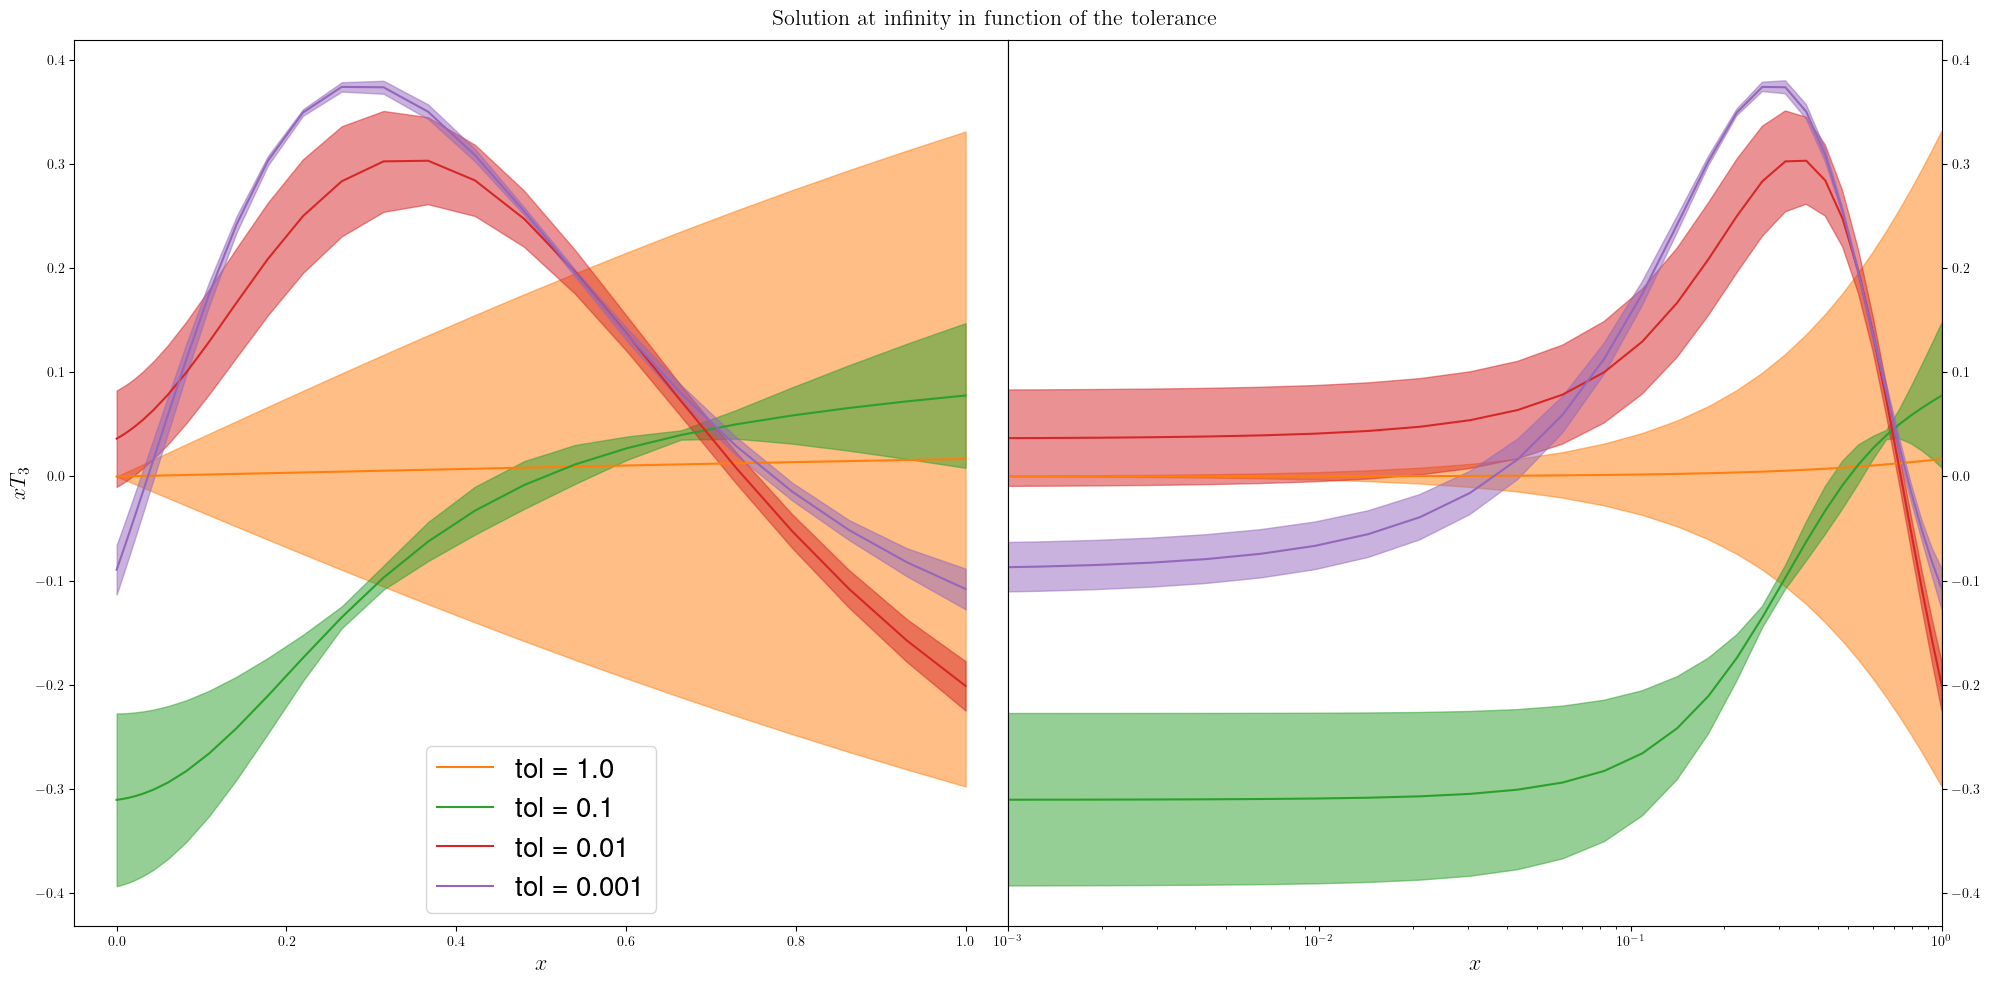

In [16]:
# Loop over toleraces and compute the evolution operator at infinity
list_of_tolerance = [
    {'tol': 1., 'color': 'C1'},
    {'tol': 1.e-1, 'color': 'C2'},
    {'tol': 1.e-2, 'color': 'C3'},
    {'tol': 1.e-3, 'color': 'C4'},
]
ref_epoch = common_epochs[-1]  # Use the last common epoch as reference
fig, axs = produce_plot(list_of_tolerance, ref_epoch)

if we set ${\rm tol} = 1.0$, then we are cutting all the information and the analytical solution does not evolve, as expected. We can then restrict the range of values. 

Computing evolution operator at infinity for tolerance 0.1...
Computing evolution operator at infinity for tolerance 0.01...
Computing evolution operator at infinity for tolerance 0.001...


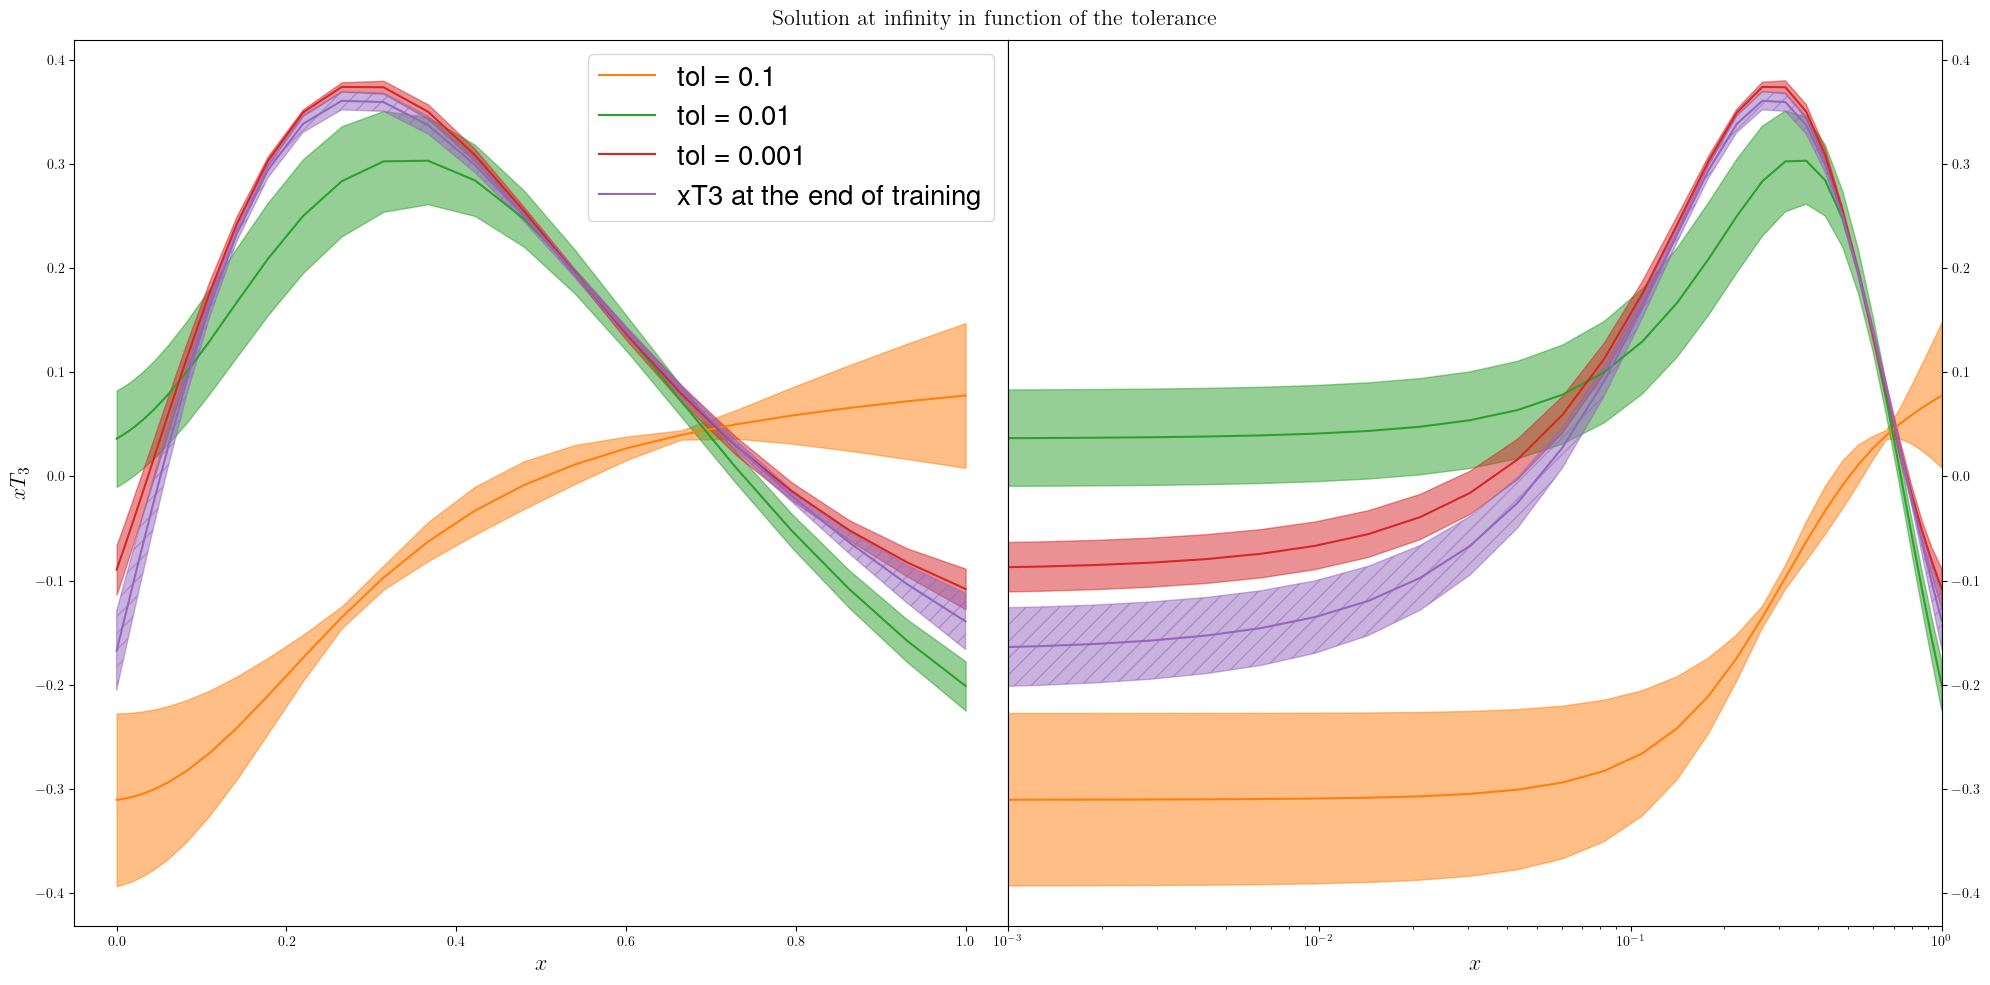

In [17]:
# Loop over toleraces and compute the evolution operator at infinity
list_of_tolerance = [
    {'tol': 1.e-1, 'color': 'C1'},
    {'tol': 1.e-2, 'color': 'C2'},
    {'tol': 1.e-3, 'color': 'C3'},
]
ref_epoch = common_epochs[-1]  # Use the last common epoch as reference
fig, axs = produce_plot(list_of_tolerance, ref_epoch)

axs[0].plot(fk_grid, xT3_training.get_mean(), 
                label='xT3 at the end of training', 
                color='C4')
axs[0].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), 
                    alpha=0.5, 
                    color='C4',
                    hatch='//')

axs[1].plot(fk_grid, xT3_training.get_mean(), 
                label='xT3 at the end of training', 
                color='C4')
axs[1].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), 
                    alpha=0.5, 
                    color='C4',
                    hatch='//')

axs[1].set_xlim(1e-3, 1)
_=axs[0].legend(fontsize=20)

If we set tol = 0.1, there is no much information left and the solution at infinity cannot evolve. We can rule it out.

Computing evolution operator at infinity for tolerance 0.01...
Computing evolution operator at infinity for tolerance 0.001...


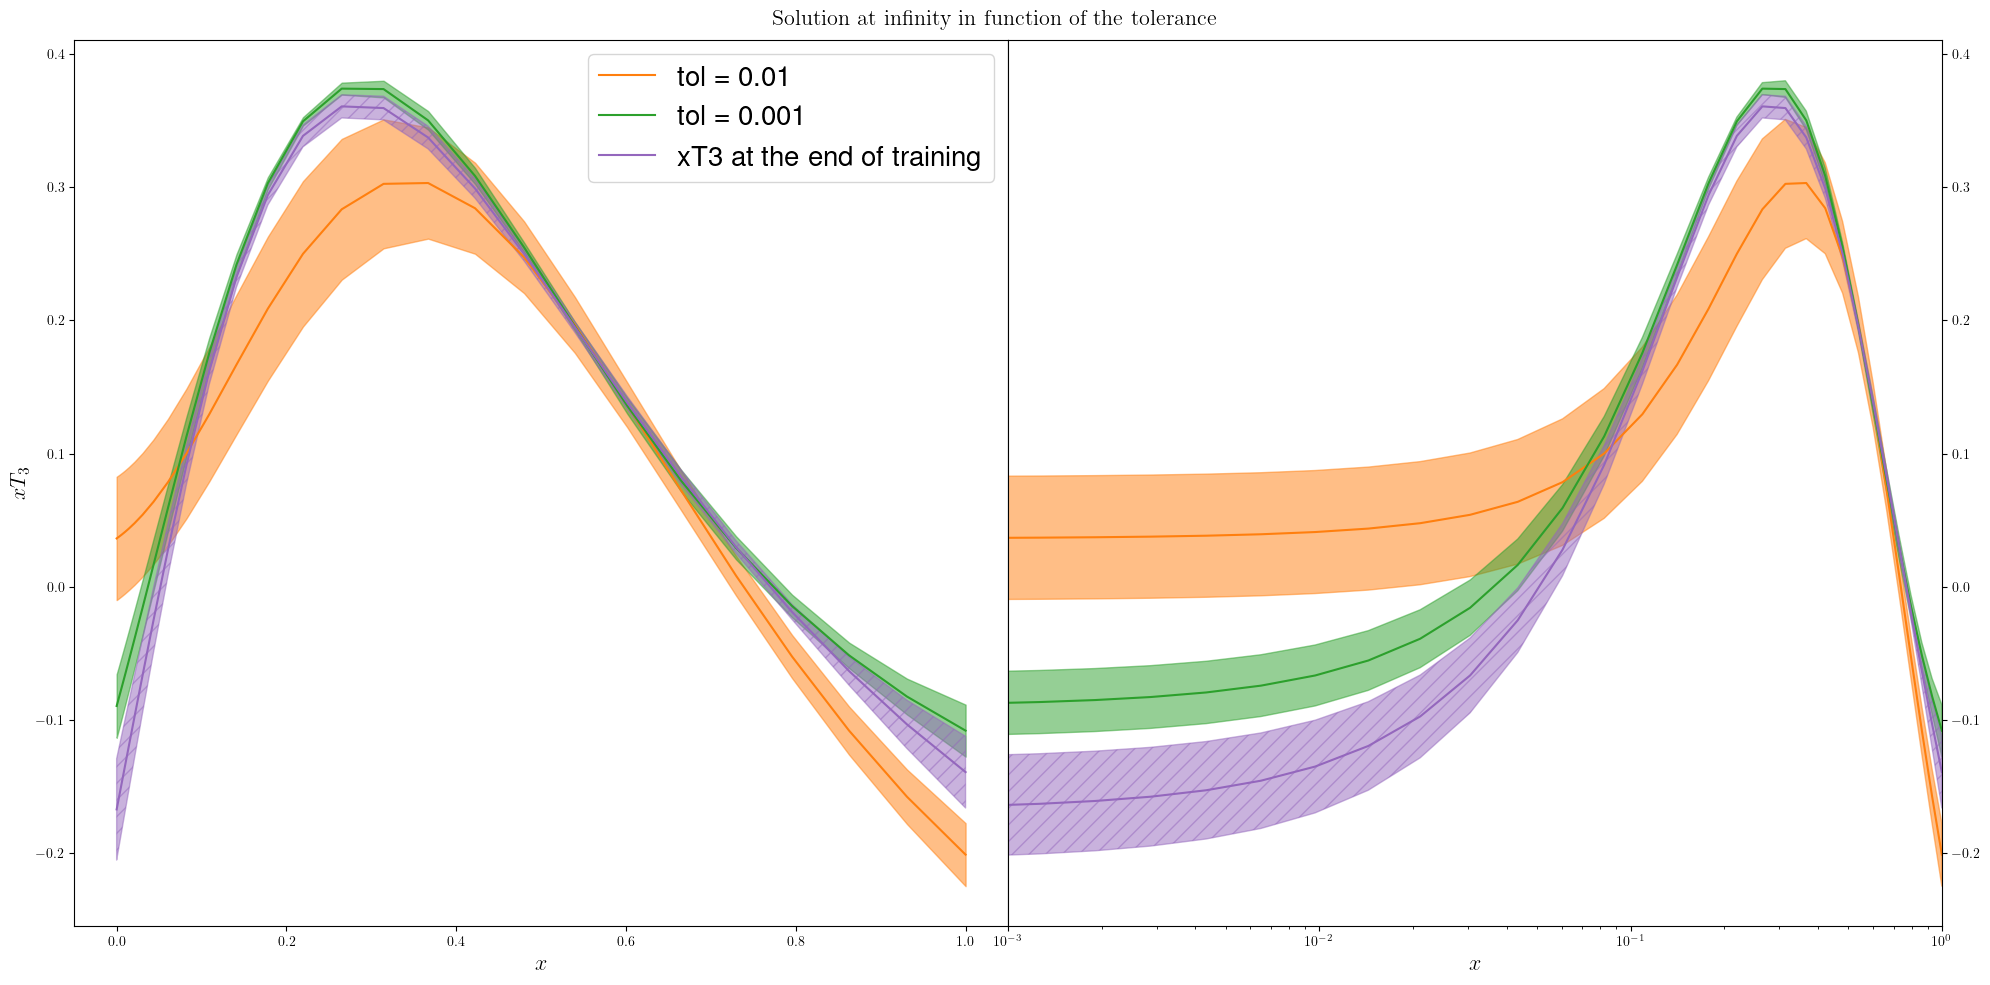

In [18]:
# Loop over toleraces and compute the evolution operator at infinity
list_of_tolerance = [
    {'tol': 1.e-2, 'color': 'C1'},
    {'tol': 1.e-3, 'color': 'C2'},
]
ref_epoch = common_epochs[-1]  # Use the last common epoch as reference
fig, axs = produce_plot(list_of_tolerance, ref_epoch)

axs[0].plot(fk_grid, xT3_training.get_mean(), 
                label='xT3 at the end of training', 
                color='C4')
axs[0].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), 
                    alpha=0.5, 
                    color='C4',
                    hatch='//')

axs[1].plot(fk_grid, xT3_training.get_mean(), 
                label='xT3 at the end of training', 
                color='C4')
axs[1].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), 
                    alpha=0.5, 
                    color='C4',
                    hatch='//')

axs[1].set_xlim(1e-3, 1)
_=axs[0].legend(fontsize=20)

Here tol = 0.01 does not look bad, but at medium-x the analytical solution is too far off. We can remove it.

Computing evolution operator at infinity for tolerance 0.001...


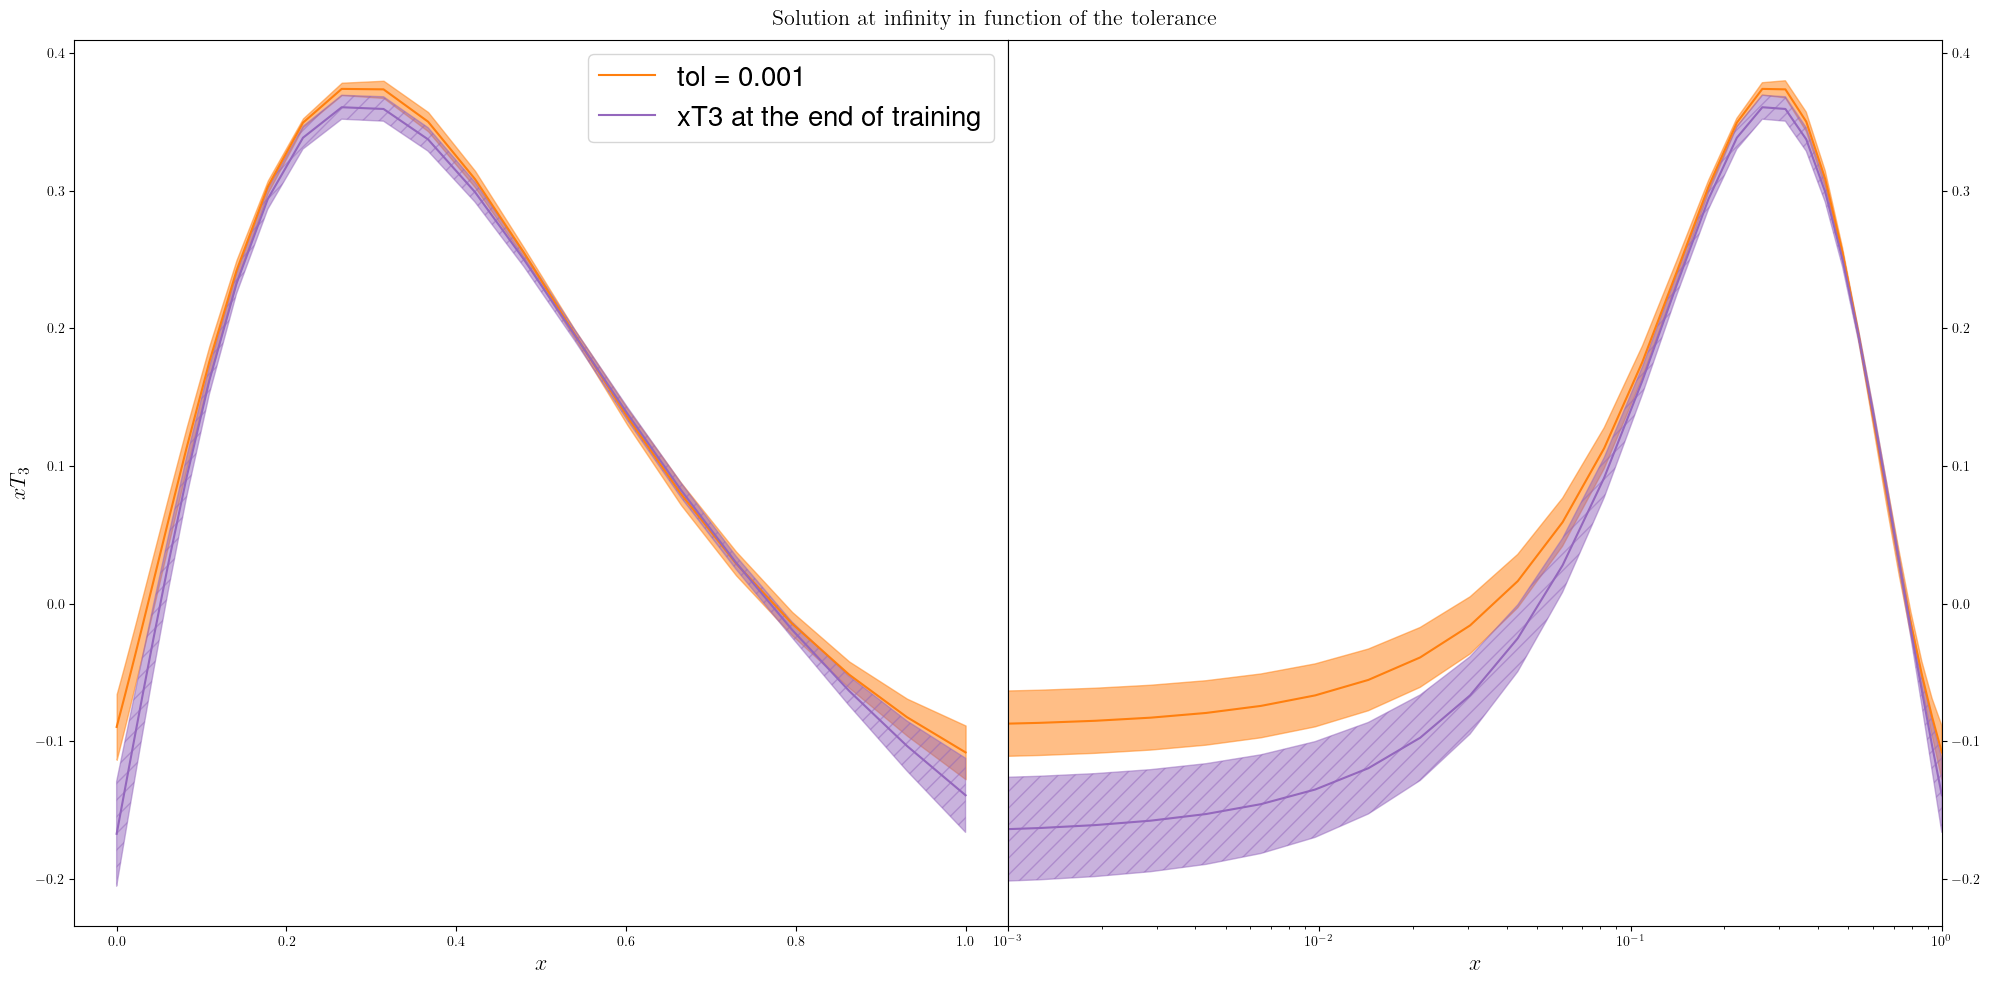

In [19]:
# Loop over toleraces and compute the evolution operator at infinity
list_of_tolerance = [
    {'tol': 1.e-3, 'color': 'C1'},
]
ref_epoch = common_epochs[-1]  # Use the last common epoch as reference
fig, axs = produce_plot(list_of_tolerance, ref_epoch)

axs[0].plot(fk_grid, xT3_training.get_mean(), 
                label='xT3 at the end of training', 
                color='C4')
axs[0].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), 
                    alpha=0.5, 
                    color='C4',
                    hatch='//')

axs[1].plot(fk_grid, xT3_training.get_mean(), 
                label='xT3 at the end of training', 
                color='C4')
axs[1].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), 
                    alpha=0.5, 
                    color='C4',
                    hatch='//')

axs[1].set_xlim(1e-3, 1)
_=axs[0].legend(fontsize=20)

This does not look bad. Let's see what happens around this value

Computing evolution operator at infinity for tolerance 0.005...
Computing evolution operator at infinity for tolerance 0.001...
Computing evolution operator at infinity for tolerance 0.0005...


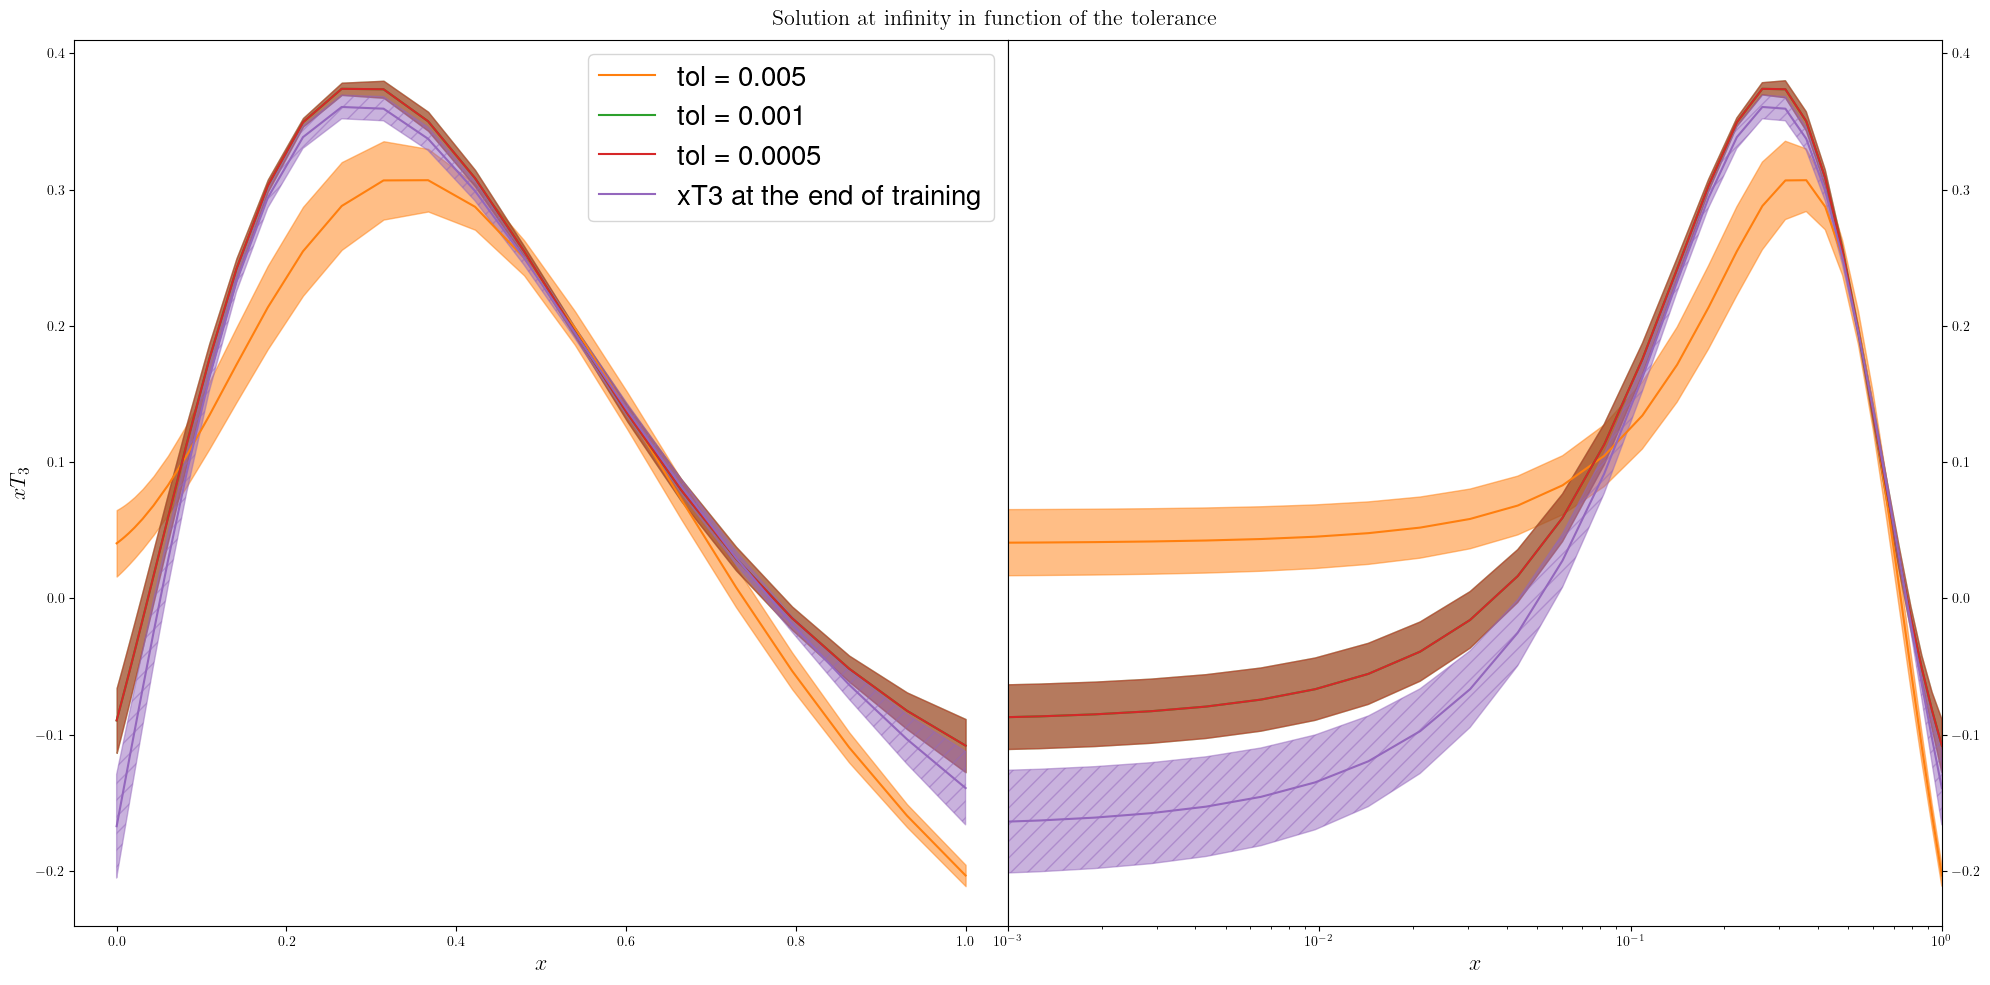

In [20]:
# Loop over toleraces and compute the evolution operator at infinity
list_of_tolerance = [
    {'tol': 5.e-3, 'color': 'C1'},
    {'tol': 1.e-3, 'color': 'C2'},
    {'tol': 5.e-4, 'color': 'C3'},
]
ref_epoch = common_epochs[-1]  # Use the last common epoch as reference
fig, axs = produce_plot(list_of_tolerance, ref_epoch)

axs[0].plot(fk_grid, xT3_training.get_mean(), 
                label='xT3 at the end of training', 
                color='C4')
axs[0].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), 
                    alpha=0.5, 
                    color='C4',
                    hatch='//')

axs[1].plot(fk_grid, xT3_training.get_mean(), 
                label='xT3 at the end of training', 
                color='C4')
axs[1].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), 
                    alpha=0.5, 
                    color='C4',
                    hatch='//')

axs[1].set_xlim(1e-3, 1)
_=axs[0].legend(fontsize=20)

Okay, probably we need to stay below 0.001.

Computing evolution operator at infinity for tolerance 0.001...
Computing evolution operator at infinity for tolerance 0.0005...
Computing evolution operator at infinity for tolerance 0.0001...


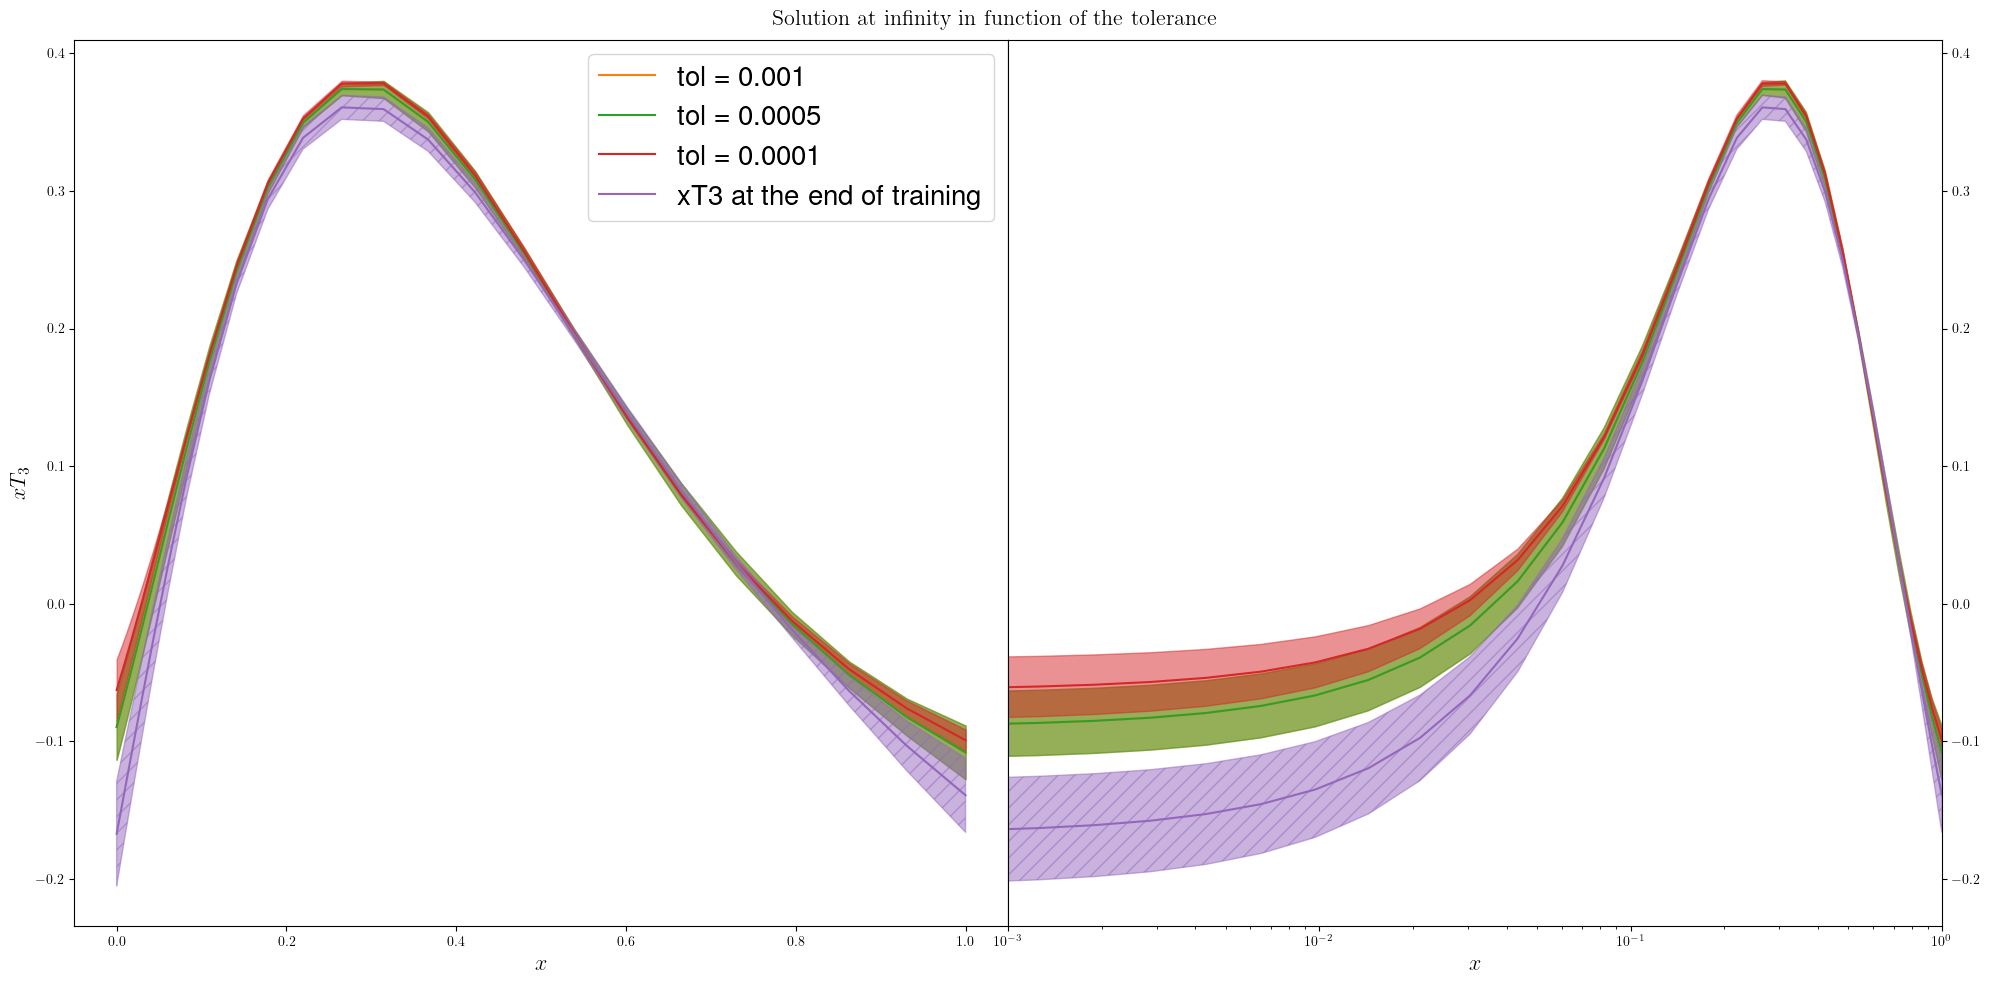

In [21]:
# Loop over toleraces and compute the evolution operator at infinity
list_of_tolerance = [
    {'tol': 1.e-3, 'color': 'C1'},
    {'tol': 5.e-4, 'color': 'C2'},
    {'tol': 1.e-4, 'color': 'C3'},
]
ref_epoch = common_epochs[-1]  # Use the last common epoch as reference
fig, axs = produce_plot(list_of_tolerance, ref_epoch)

axs[0].plot(fk_grid, xT3_training.get_mean(), 
                label='xT3 at the end of training', 
                color='C4')
axs[0].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), 
                    alpha=0.5, 
                    color='C4',
                    hatch='//')

axs[1].plot(fk_grid, xT3_training.get_mean(), 
                label='xT3 at the end of training', 
                color='C4')
axs[1].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), 
                    alpha=0.5, 
                    color='C4',
                    hatch='//')

axs[1].set_xlim(1e-3, 1)
_=axs[0].legend(fontsize=20)

Computing evolution operator at infinity for tolerance 1e-05...
Computing evolution operator at infinity for tolerance 1e-06...


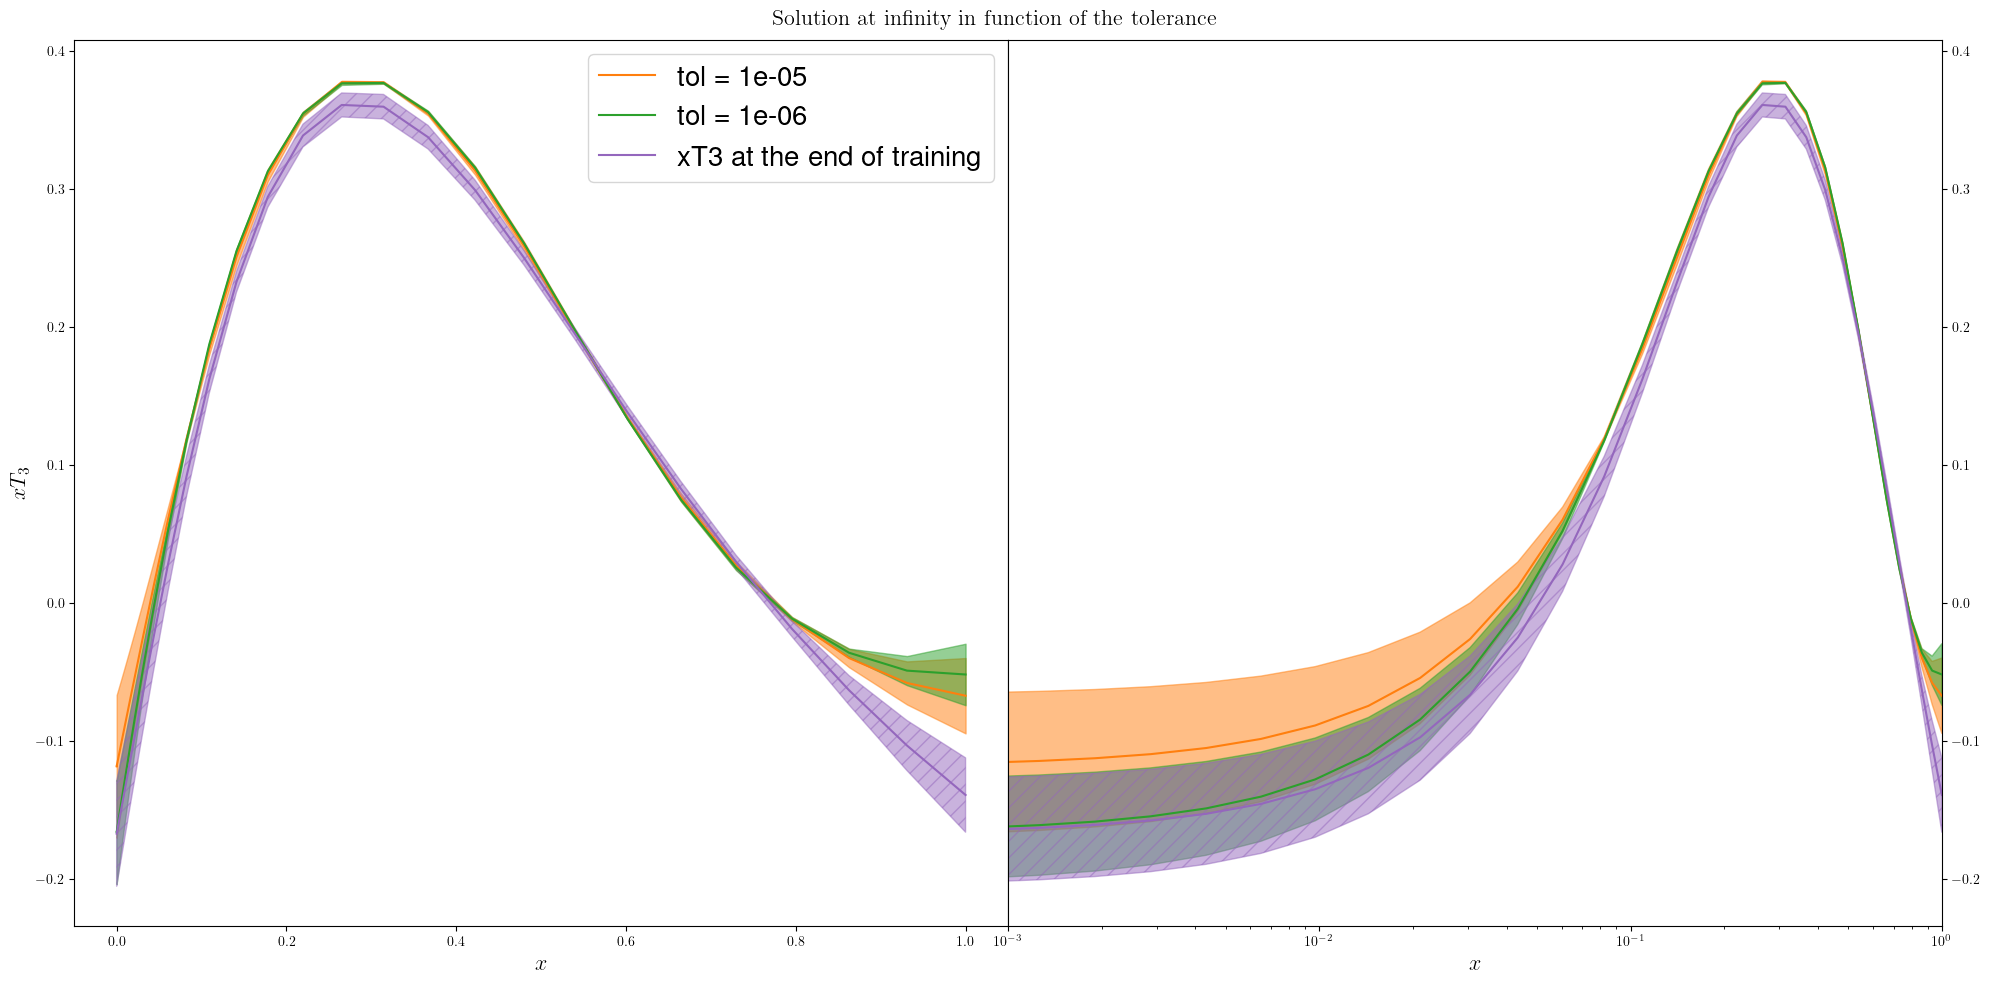

In [22]:
# Loop over toleraces and compute the evolution operator at infinity
list_of_tolerance = [
    {'tol': 1.e-5, 'color': 'C1'},
    {'tol': 1.e-6, 'color': 'C2'},
]
ref_epoch = common_epochs[-1]  # Use the last common epoch as reference
fig, axs = produce_plot(list_of_tolerance, ref_epoch)

axs[0].plot(fk_grid, xT3_training.get_mean(), 
                label='xT3 at the end of training', 
                color='C4')
axs[0].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), 
                    alpha=0.5, 
                    color='C4',
                    hatch='//')

axs[1].plot(fk_grid, xT3_training.get_mean(), 
                label='xT3 at the end of training', 
                color='C4')
axs[1].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), 
                    alpha=0.5, 
                    color='C4',
                    hatch='//')

axs[1].set_xlim(1e-3, 1)
_=axs[0].legend(fontsize=20)

Computing evolution operator at infinity for tolerance 1e-05...


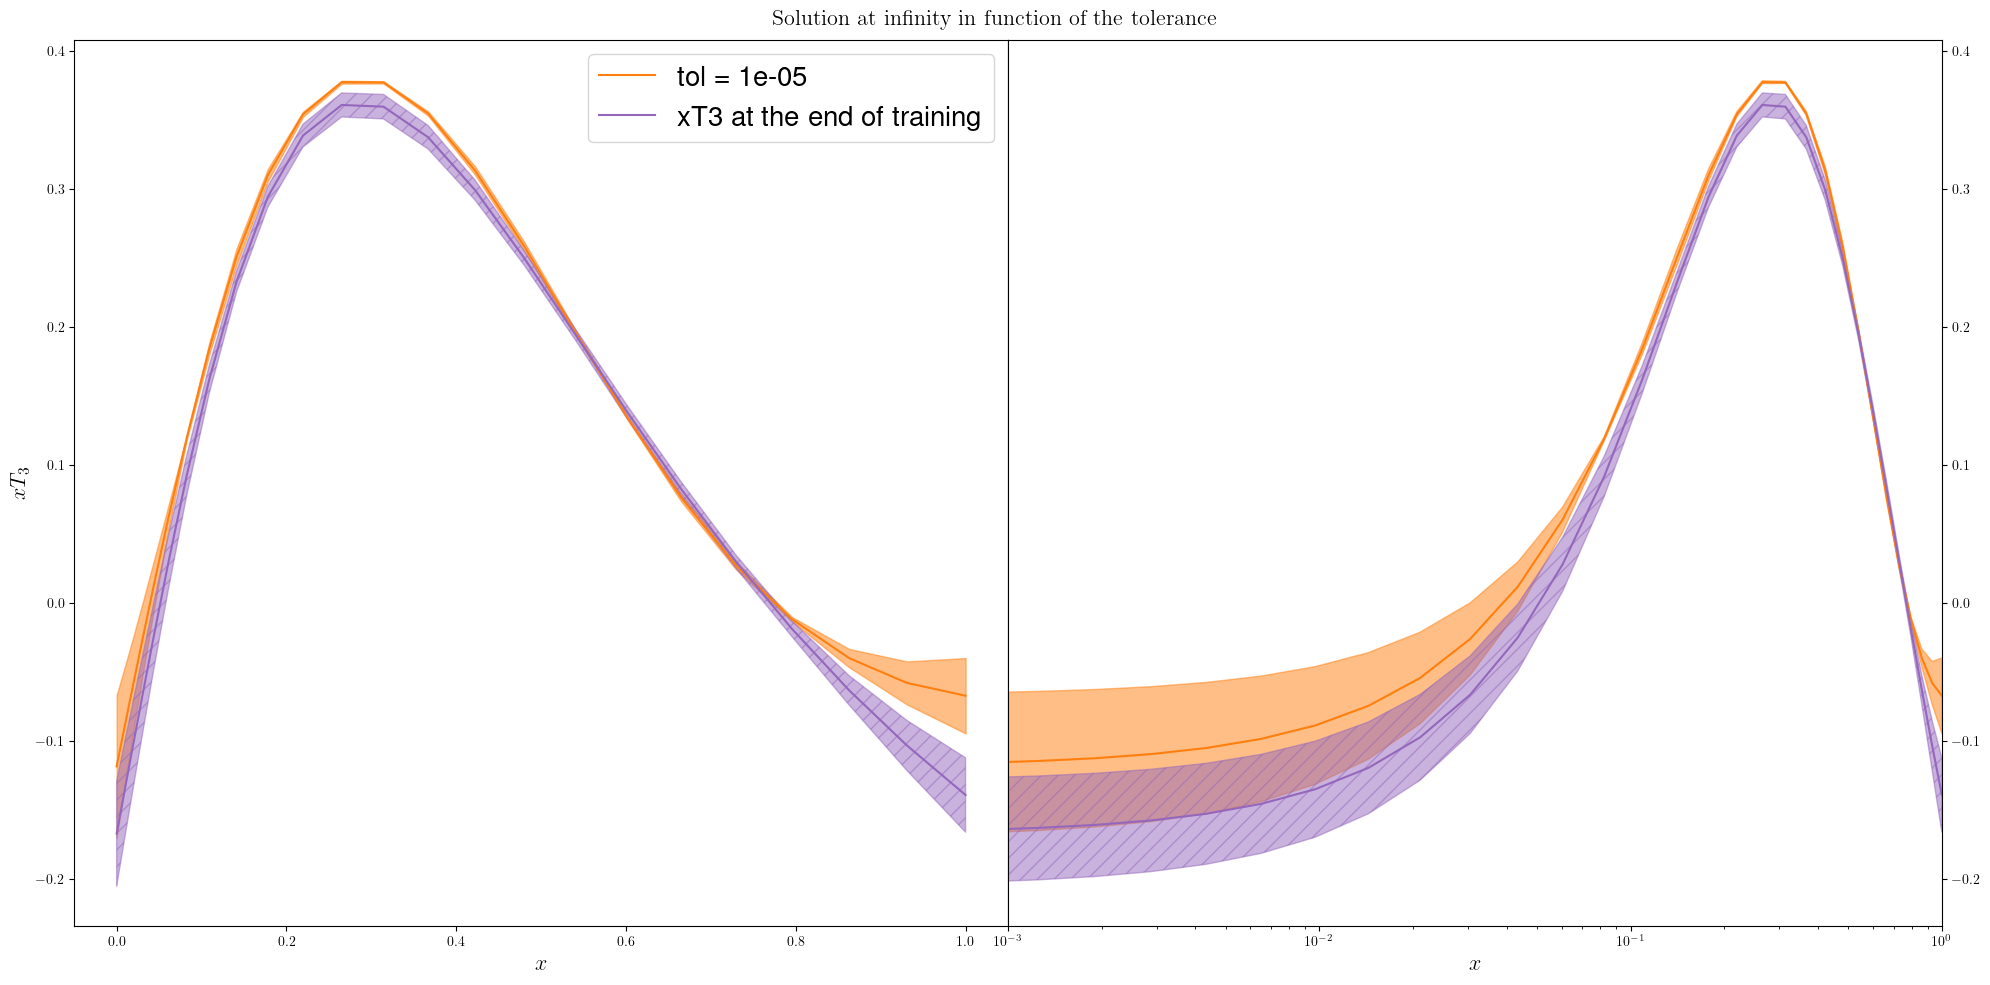

In [23]:
# Loop over toleraces and compute the evolution operator at infinity
list_of_tolerance = [
    {'tol': 1.e-5, 'color': 'C1'},
]
ref_epoch = common_epochs[-1]  # Use the last common epoch as reference
fig, axs = produce_plot(list_of_tolerance, ref_epoch)

axs[0].plot(fk_grid, xT3_training.get_mean(), 
                label='xT3 at the end of training', 
                color='C4')
axs[0].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), 
                    alpha=0.5, 
                    color='C4',
                    hatch='//')

axs[1].plot(fk_grid, xT3_training.get_mean(), 
                label='xT3 at the end of training', 
                color='C4')
axs[1].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), 
                    alpha=0.5, 
                    color='C4',
                    hatch='//')

axs[1].set_xlim(1e-3, 1)
_=axs[0].legend(fontsize=20)

Computing evolution operator at infinity for tolerance 0.005...


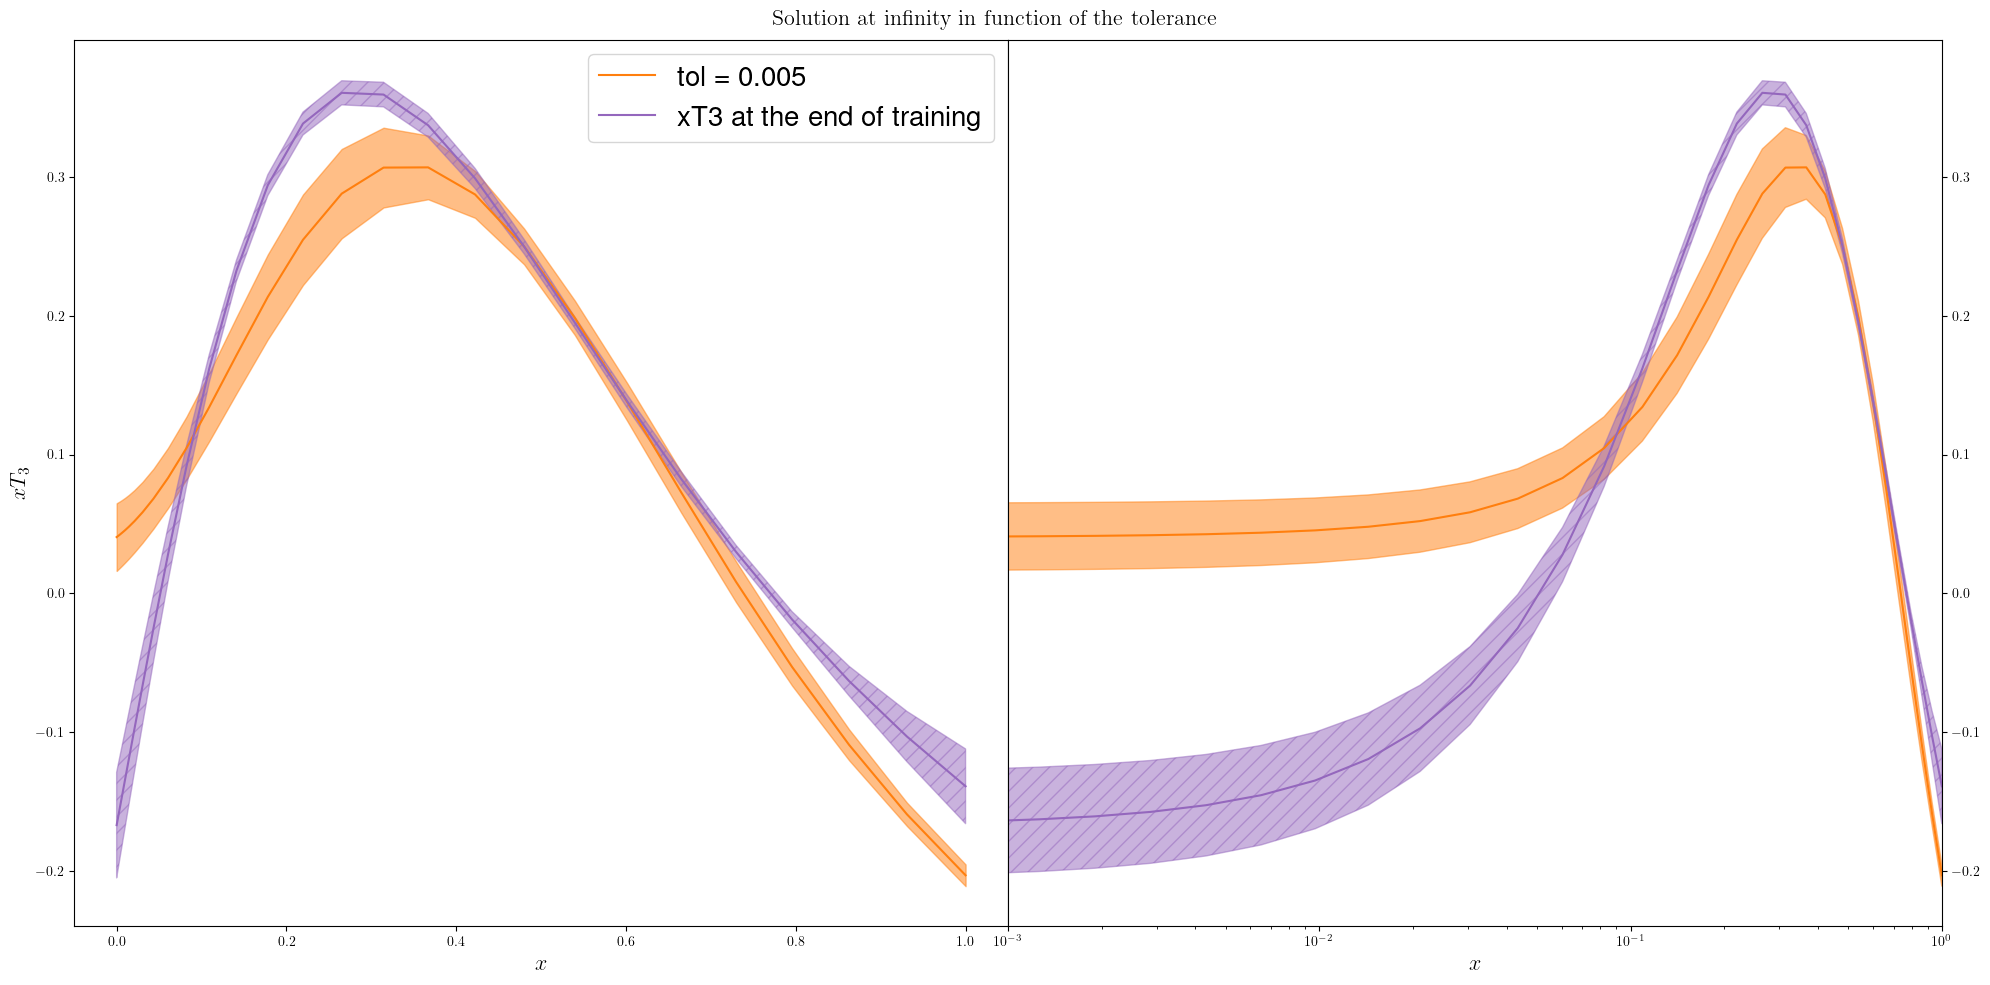

In [24]:
# Loop over toleraces and compute the evolution operator at infinity
list_of_tolerance = [
    {'tol': 0.005, 'color': 'C1'},
]
ref_epoch = common_epochs[-1]  # Use the last common epoch as reference
fig, axs = produce_plot(list_of_tolerance, ref_epoch)

axs[0].plot(fk_grid, xT3_training.get_mean(), 
                label='xT3 at the end of training', 
                color='C4')
axs[0].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), 
                    alpha=0.5, 
                    color='C4',
                    hatch='//')

axs[1].plot(fk_grid, xT3_training.get_mean(), 
                label='xT3 at the end of training', 
                color='C4')
axs[1].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), 
                    alpha=0.5, 
                    color='C4',
                    hatch='//')

axs[1].set_xlim(1e-3, 1)
_=axs[0].legend(fontsize=20)